# Import thư viện

In [1]:
from tsai.all import *
from tsai.imports import *
from tsai.utils import *
from tsai.models.layers import *
from tsai.models.utils import *

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import math
from keras.models import Sequential
from keras.layers import Dense,LSTM
import os.path
from os import path
from pylab import rcParams
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import freq_to_period
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import pickle
import os
import joblib

# Phân tích dữ liệu

In [3]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Performance metrics calculation support library
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt


df = pd.read_csv('ABBV-AbbVie.csv')
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

# Select the Close column as the dependent variable
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))
data_scaled = np.squeeze(data_scaled)

In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,118.333645,119.519293,117.180683,118.409444,107.480335,7.156615e+06
std,30.707708,30.939707,30.547506,30.792027,33.895028,4.505989e+06
min,63.509998,64.239998,62.549999,62.980000,50.956902,1.378600e+06
25%,89.605000,90.405003,88.845001,89.474998,75.054756,4.851750e+06
50%,115.480003,116.519997,114.519997,115.610001,103.013306,6.148100e+06
75%,147.525001,148.875000,146.159996,147.504998,139.818848,8.157300e+06
max,179.850006,179.889999,178.000000,178.990005,177.333878,9.013180e+07


In [5]:
df['Close']

Date
2019-03-01     80.099998
2019-03-04     79.459999
2019-03-05     78.910004
2019-03-06     78.089996
2019-03-07     78.239998
                 ...    
2024-02-23    178.089996
2024-02-26    178.809998
2024-02-27    178.990005
2024-02-28    178.000000
2024-02-29    176.050003
Name: Close, Length: 1259, dtype: float64

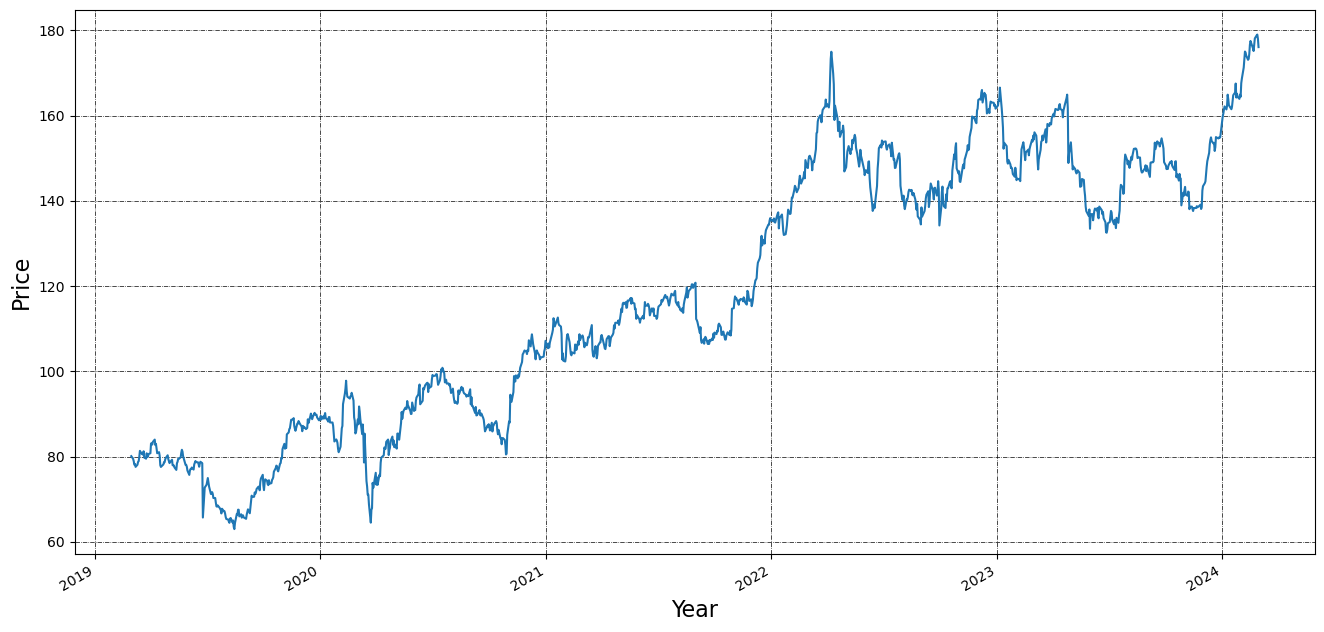

In [6]:
import matplotlib.ticker as ticker

df['Close'].plot(figsize=(16, 8))

plt.ylabel('Price', fontsize=16)
plt.xlabel('Year', fontsize=16)

plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)

plt.show()

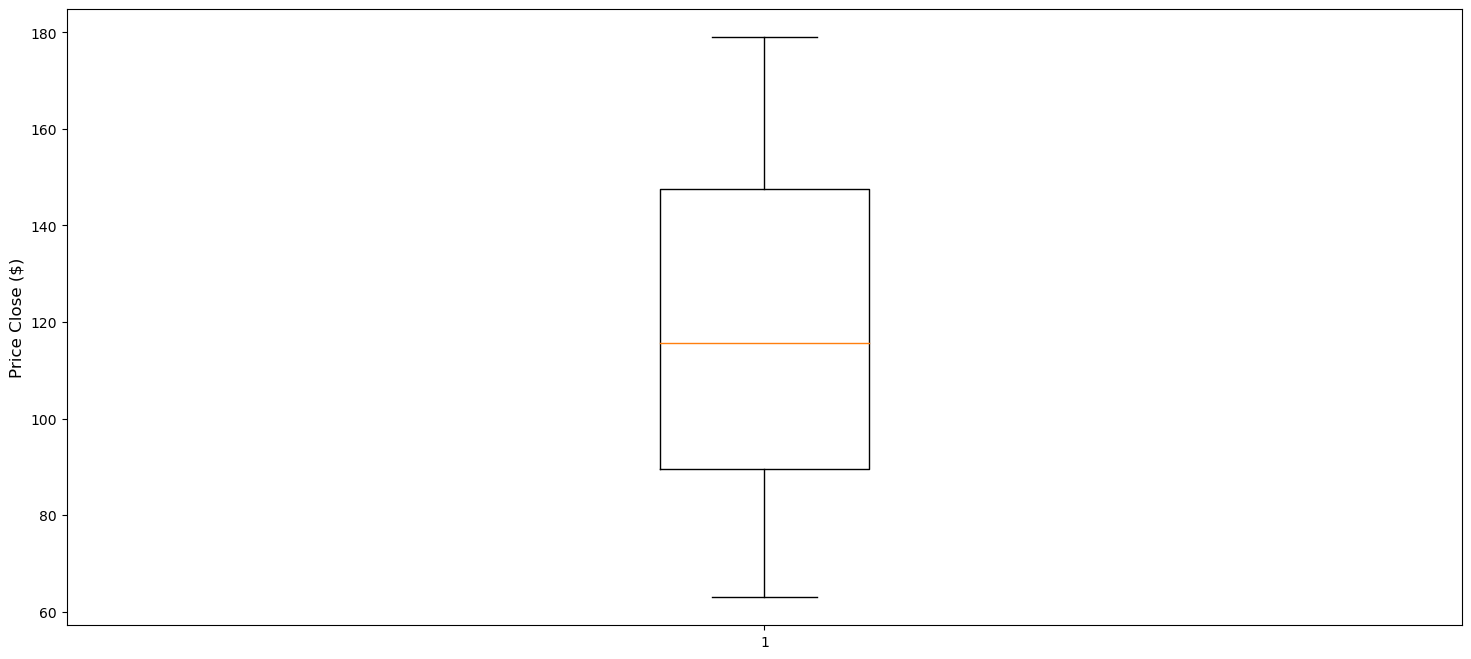

In [7]:
plt.figure(figsize=(18, 8))
plt.boxplot(df['Close'])
plt.ylabel("Price Close ($)", fontsize=12)
plt.show()

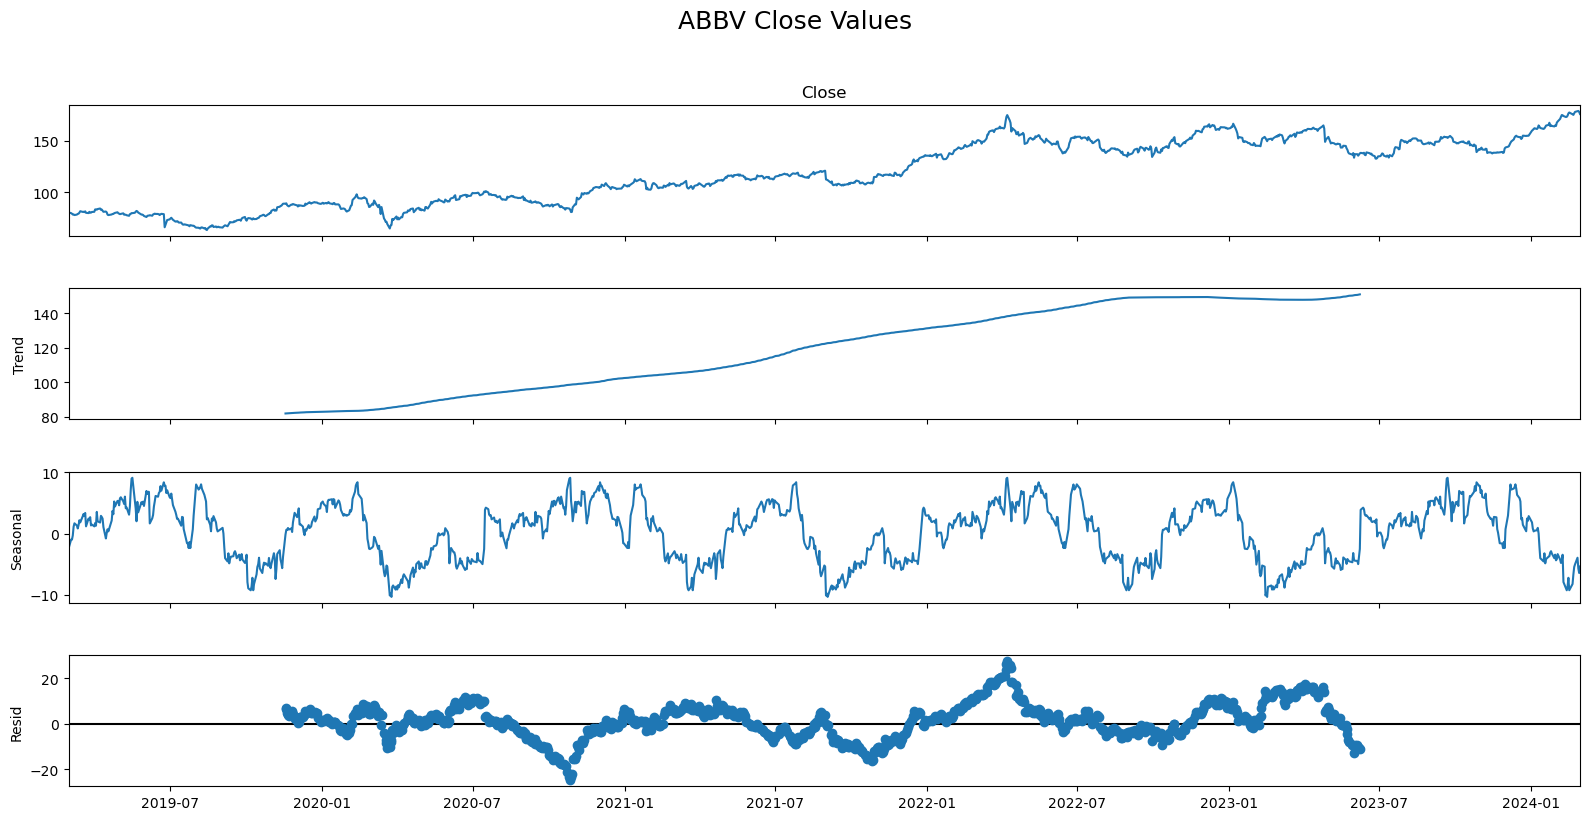

In [8]:
rcParams['figure.figsize'] = 16,8
decomposition = seasonal_decompose(df['Close'], model = 'additive', period = 365)
fig = decomposition.plot()
# Đặt tiêu đề cho biểu đồ với khoảng cách y thích hợp
fig.suptitle('ABBV Close Values', fontsize=18, y=1.02)

# Điều chỉnh khoảng cách giữa các phần của biểu đồ
plt.subplots_adjust(top=0.9, hspace=0.4)
plt.show()

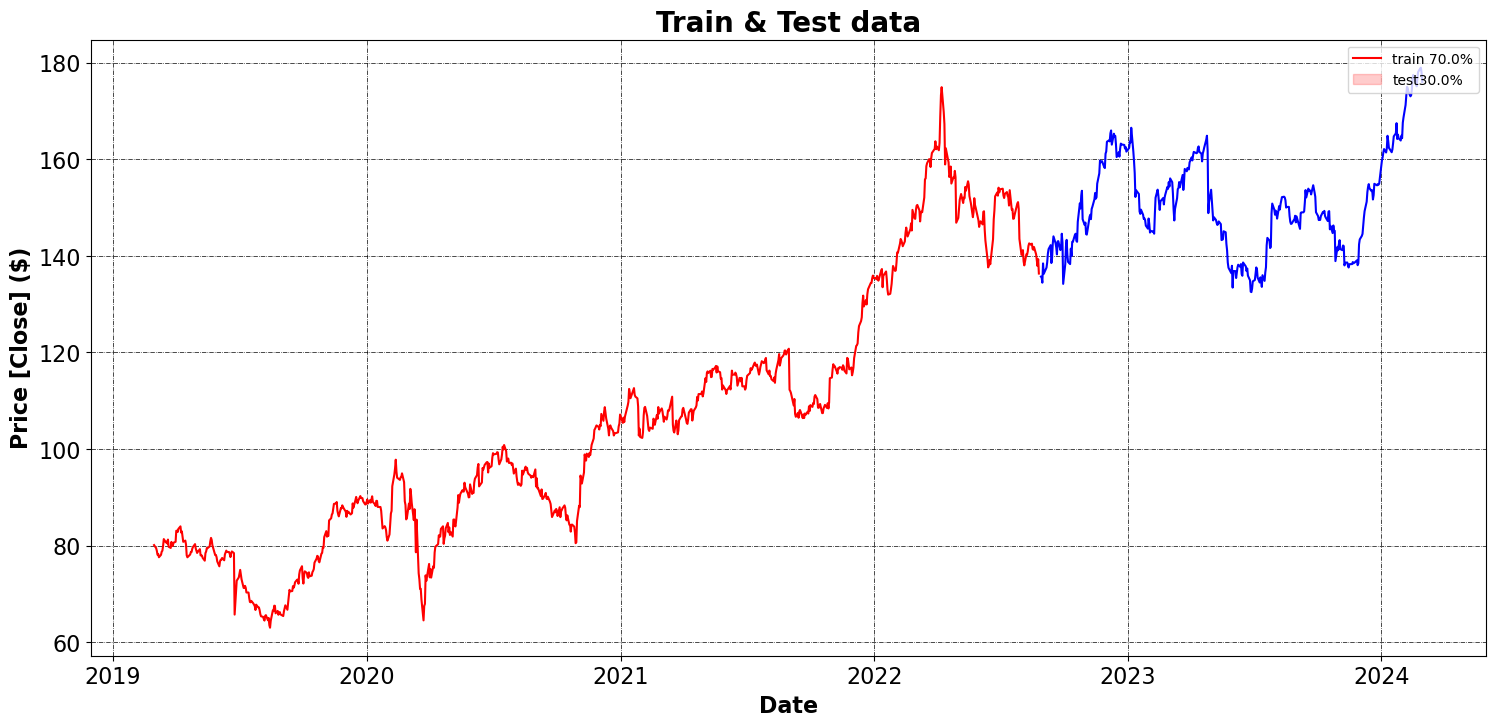

In [9]:
size = 0.7  # Chia train test
size_train = int(len(df) * size)
fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = df.index[:size_train], y = df['Close'][:size_train], color = 'red')
sns.lineplot(x = df.index[size_train:], y = df['Close'][size_train:], color = 'blue')

ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close] ($)', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train ' + str(size*100) + '%', 'test'+ str(100 - size*100) + '%'))
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()

In [10]:
print("Tập train:")
print(df[:size_train]['Close'].describe())
print("")
print("Tập test:")
print(df[size_train:]['Close'].describe())

Tập train:
count    881.000000
mean     104.569148
std       25.908073
min       62.980000
25%       83.959999
50%      102.480003
75%      116.870003
max      174.960007
Name: Close, dtype: float64

Tập test:
count    378.000000
mean     150.666852
std       10.301471
min      132.509995
25%      142.957500
50%      149.260002
75%      157.979999
max      178.990005
Name: Close, dtype: float64


# Mô hình

In [11]:
#|export
class _ResCNNBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3], coord=False, separable=False, zero_norm=False):
        self.convblock1 = ConvBlock(ni, nf, kss[0], coord=coord, separable=separable)
        self.convblock2 = ConvBlock(nf, nf, kss[1], coord=coord, separable=separable)
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None, coord=coord, separable=separable, zero_norm=zero_norm)

        # expand channels for the sum if necessary
        self.shortcut = ConvBN(ni, nf, 1, coord=coord)
        self.add = Add()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x, self.shortcut(res))
        x = self.act(x)
        return x


class ResCNN(Module):
    def __init__(self, c_in, c_out, coord=False, separable=False, zero_norm=False):
        nf = 64
        self.block1 = _ResCNNBlock(c_in, nf, kss=[7, 5, 3], coord=coord, separable=separable, zero_norm=zero_norm)
        self.block2 = ConvBlock(nf, nf * 2, 3, coord=coord, separable=separable, act=nn.LeakyReLU, act_kwargs={'negative_slope':.2})
        self.block3 = ConvBlock(nf * 2, nf * 4, 3, coord=coord, separable=separable, act=nn.PReLU)
        self.block4 = ConvBlock(nf * 4, nf * 2, 3, coord=coord, separable=separable, act=nn.ELU, act_kwargs={'alpha':.3})
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.squeeze = Squeeze(-1)
        self.lin = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.squeeze(self.gap(x))
        return self.lin(x)

class ResCNN_LSTM(Module):
    def __init__(self, c_in, c_out, hidden_dim, num_layers, coord=False, separable=False, zero_norm=False):
        super().__init__()
        self.ResCNN = ResCNN(c_in, hidden_dim, coord=coord, separable=separable, zero_norm=zero_norm)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, c_out)

    def forward(self, x):
        x = self.ResCNN(x)
        x, _ = self.LSTM(x.unsqueeze(0))
        x = self.fc(x.squeeze(0))
        return x


In [12]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

# Chia dữ liệu thành các cặp input-output
X = []
y = []
day_in = 50 # Số lượng input ngày khi đi vào model
day_out = 60 # Số lượng ngày dự đoán tiếp theo
# => ngày 1->50 dư đoán ngày 51->80
# => ngày 2->51 dư đoán ngày 52->81
# .....
for i in range(len(data_scaled) - (day_in + day_out)):
    X.append(data_scaled[i:i+day_in])
    y.append(data_scaled[i+day_in:i+day_out+ day_in])

# Chia dữ liệu thành tập train và test
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Chuyển dữ liệu thành tensor và tạo DataLoader
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_train, dtype=torch.float32))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1), torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [13]:
# Khởi tạo model và optimizer
model = ResCNN_LSTM(day_in, day_out, 64, 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện model
num_epoch = 100
for epoch in range(num_epoch):
    print("epoch: " + str(epoch) + " ===================================================")
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = nn.MSELoss()(output, batch_y)
        loss.backward()
        # print(loss)
        optimizer.step()

epoch: 0 ===================================================
epoch: 1 ===================================================
epoch: 2 ===================================================
epoch: 3 ===================================================
epoch: 4 ===================================================
epoch: 5 ===================================================
epoch: 6 ===================================================
epoch: 7 ===================================================
epoch: 8 ===================================================
epoch: 9 ===================================================
epoch: 10 ===================================================
epoch: 11 ===================================================
epoch: 12 ===================================================
epoch: 13 ===================================================
epoch: 14 ===================================================
epoch: 15 ===================================================
epoch: 16 ========

In [14]:
# Chọn một mẫu dữ liệu từ tập test
test_sample = data_scaled[-day_in:]

# Chuyển mẫu dữ liệu thành tensor và thêm một chiều batch
test_sample_tensor = torch.tensor(test_sample, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

# Dự đoán với mô hình
model.eval()  # Chuyển mô hình sang chế độ đánh giá
with torch.no_grad():  # Tắt việc tính toán gradient
    predictions = model(test_sample_tensor)
    predictions = predictions.squeeze().numpy()
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# In ra kết quả dự đoán
print(predictions)

[[145.3171 ]
 [144.97939]
 [144.31369]
 [145.89432]
 [145.78844]
 [147.72057]
 [149.59808]
 [147.63469]
 [144.45468]
 [145.70341]
 [147.47739]
 [148.90985]
 [143.65466]
 [146.4214 ]
 [147.22086]
 [148.05048]
 [148.569  ]
 [147.36264]
 [146.99734]
 [149.50682]
 [147.13724]
 [146.59215]
 [147.19356]
 [147.55452]
 [147.69835]
 [150.60957]
 [144.86067]
 [145.60362]
 [147.4432 ]
 [144.93051]
 [145.35468]
 [146.81534]
 [148.95178]
 [146.17197]
 [145.7919 ]
 [146.48558]
 [146.28706]
 [145.49341]
 [147.01144]
 [145.93977]
 [148.4741 ]
 [149.21133]
 [146.19377]
 [147.92543]
 [147.10115]
 [145.19774]
 [144.54099]
 [145.18317]
 [149.14183]
 [149.75577]
 [150.29695]
 [147.8088 ]
 [142.88618]
 [147.4971 ]
 [148.8329 ]
 [145.76505]
 [147.24202]
 [146.62132]
 [146.85635]
 [145.20888]]


In [15]:
train_60 = df_Close['Close']
train_60

0        80.099998
1        79.459999
2        78.910004
3        78.089996
4        78.239998
           ...    
1254    178.089996
1255    178.809998
1256    178.990005
1257    178.000000
1258    176.050003
Name: Close, Length: 1259, dtype: float64

In [16]:
train_60 = df_Close['Close']
series_data = pd.Series(predictions.squeeze())
new_start_index = train_60.index[-1] + 1
series_data.index = range(new_start_index, new_start_index + len(series_data))

# Nối hai series lại với nhau
train_60_pre = pd.concat([train_60, series_data])

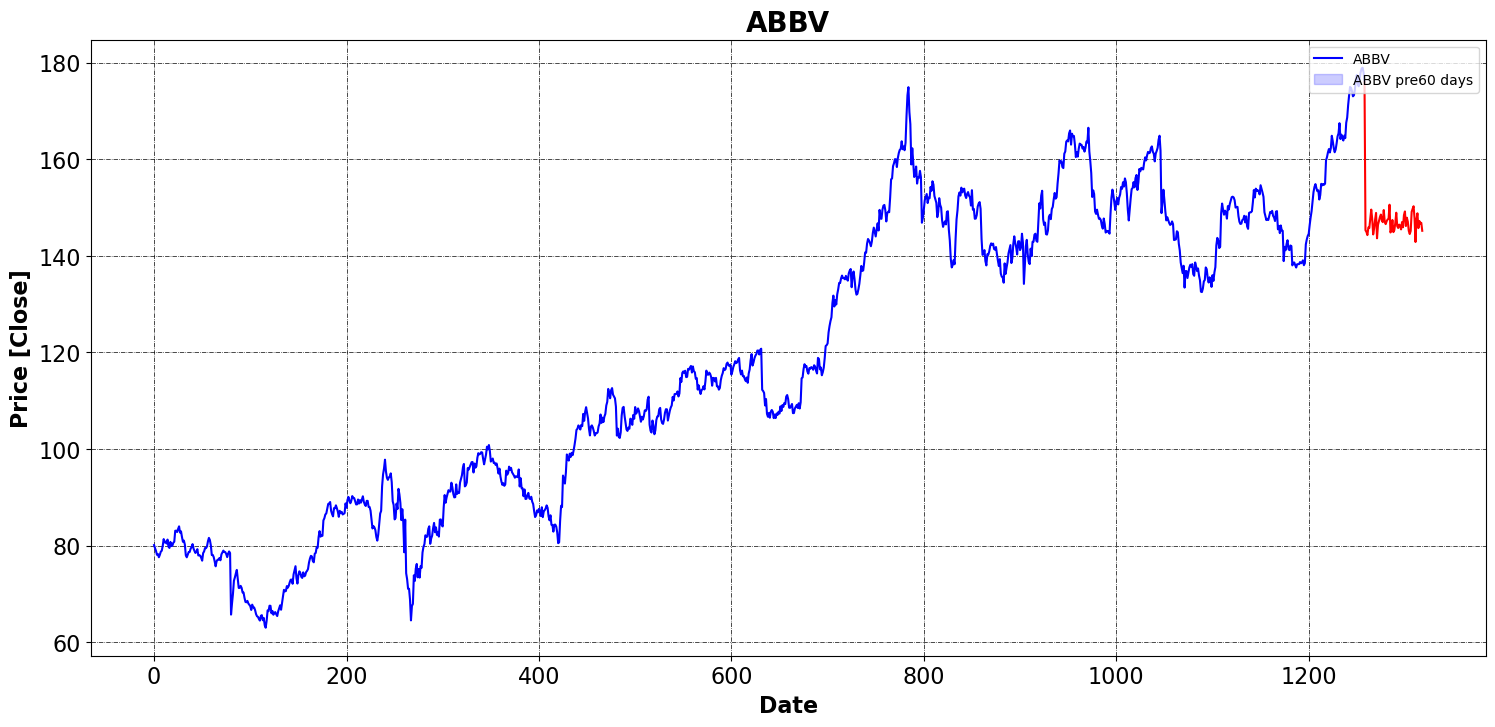

In [17]:
train_60 = df_Close['Close']
series_data = pd.Series(predictions.squeeze())
new_start_index = train_60.index[-1] + 1
series_data.index = range(new_start_index, new_start_index + len(series_data))

# Nối hai series lại với nhau
train_60_pre = pd.concat([train_60, series_data])

fig, ax = plt.subplots(figsize=(18,8)) # 4.5, 2
sns.lineplot(x = df_Close.index[:], y = df_Close['Close'][:], color = 'blue')
sns.lineplot(x = train_60_pre.index[-(day_out+1):], y = train_60_pre.values[-(day_out+1):], color = 'red')
# sns.lineplot(data = train_60_pre[-60:])
ax.set_title('ABBV', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price [Close]', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('ABBV', 'ABBV pre' + str(day_out) + ' days'))
plt.grid(which="major", color='k', linestyle='-.', linewidth=0.5)
plt.show()